In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import re
from argparse import Namespace

sys.path.append('../src-py/')

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
%autoreload

from utils import *
from project_debater_api import *
from mt_bart_v2 import *

In [4]:
import pickle
import torch
import json

import nltk
import numpy as np
import pandas as pd

from pathlib import Path
from tabulate import tabulate
pd.set_option('display.max_colwidth', None)

In [ ]:
from datasets import load_dataset, load_metric, Dataset

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import BertForSequenceClassification, AutoTokenizer, TextClassificationPipeline, AutoModelForSequenceClassification

from transformers import BartTokenizer, BartForConditionalGeneration

import matplotlib.pyplot as plt

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [9]:
ceph_dir = '/home/sile2804/data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation'
local_home_dir = '../data'

In [10]:
def generate_ds_attacks(ds, model, tokenizer, premises_clm, conclusion_clm, gen_kwargs, skip_special_tokens=True, batch_size=10):
    ds = ds.map(lambda x :preprocess_function(x, tokenizer, premises_clm, 'counter', conclusion_clm=conclusion_clm), batched=True)
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size)
    attacks = generate_counters(model, tokenizer, dataloader, gen_kwargs, skip_special_tokens=skip_special_tokens)
    
    return attacks

def create_predictions_df(reddit_sample_valid_ds, gen_kwargs, premises_clm='masked_premises'):
    
    joint_attacks       = generate_ds_attacks(reddit_sample_valid_ds, join_model, join_model_tokenizer, premises_clm, None, gen_kwargs)
    
    known_conc_attacks  = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'title', gen_kwargs)
    noconc_attacks      = generate_ds_attacks(reddit_sample_valid_ds, no_conclusion_model, no_conclusion_tokenizer, premises_clm, None, gen_kwargs)
    bart_conc_attacks   = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'bart_conclusion', gen_kwargs)
    masked_conc_attacks = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, None, gen_kwargs)
    
    #update max_gen_length to account to the generated conclusion
    gen_kwargs['max_length'] = gen_kwargs['max_length'] + 30
    joint_conc_baseline_attacks  = generate_ds_attacks(reddit_sample_valid_ds, pred_conclusion_model, pred_conclusion_tokenizer, premises_clm, None, gen_kwargs, skip_special_tokens=False)
    planning_attacks             = generate_ds_attacks(reddit_sample_valid_ds, planning_model, planning_model_tokenizer, premises_clm, None, gen_kwargs, skip_special_tokens=False)
    #This model would predict the conclusion and then the counter in one sequence.

    reddit_pred_df = pd.DataFrame(list(zip(
                                           reddit_sample_valid_ds['post_id'],
                                           reddit_sample_valid_ds['title'], 
                                           reddit_sample_valid_ds['conclusion_targets'],
                                           reddit_sample_valid_ds['conclusion_stance'],
                                           reddit_sample_valid_ds['bart_conclusion'], 
                                           reddit_sample_valid_ds[premises_clm],
                                           reddit_sample_valid_ds['counter'], 
                                           known_conc_attacks, noconc_attacks, masked_conc_attacks, 
                                           bart_conc_attacks, joint_attacks, joint_conc_baseline_attacks, planning_attacks)), 
                    columns=['post_id', 'conclusion', 'conclusion_target', 'conclusion_stance', 'bart_conclusion', 'premises', 'gt_attack', 'known_conc_attacks', 
                             'no_conc_attacks', 'masked_conc_attacks', 'bart_conc_attacks', 'joint_conc_attacks', 'joint_conc_baseline_attacks', 'planning_attacks'])

    reddit_pred_df['argument'] = reddit_pred_df.apply(lambda row: row['conclusion'] + ' : ' + ' '.join(row['premises']), axis=1)
    reddit_pred_df['premises'] = reddit_pred_df['premises'].apply(lambda x: ' '.join(x))

    #process the jointly generated conclusion and counter
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[0])
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[1] if '<counter>' in x else x)
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())

    #similar to the jointly generated conclusion and counter
    reddit_pred_df['planning_counter_claim']  = reddit_pred_df['planning_attacks'].apply (lambda x: x.split('<counter>')[0])
    reddit_pred_df['planning_counter_attack'] = reddit_pred_df['planning_attacks'].apply (lambda x: x.split('<counter>')[1] if '<counter>' in x else x)
    reddit_pred_df['planning_counter_claim']  = reddit_pred_df['planning_counter_claim'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())
    reddit_pred_df['planning_counter_attack'] = reddit_pred_df['planning_counter_attack'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())

    
    return reddit_pred_df

    
def get_evaluation_results(reddit_pred_df, df_path):
    
    #collect references
    df = pd.read_pickle(df_path)
    arg_counters = df.groupby('post_id').agg({
        'counter': lambda x: [' '.join(c) for c in x]
    }).reset_index()

    arg_counters = pd.Series(arg_counters.counter.values, index=arg_counters.post_id).to_dict()

    reddit_pred_df['all_counters'] = reddit_pred_df['post_id'].apply(lambda x: arg_counters[x])
    reddit_pred_df['all_counters'] = reddit_pred_df.all_counters.apply(lambda claims: [c for c in claims if c !=''])
    reddit_pred_df = reddit_pred_df[reddit_pred_df.all_counters.map(len) > 0]


    masked_conc_eval   = evaluate_gen_attacks(reddit_pred_df['masked_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    no_conc_eval       = evaluate_gen_attacks(reddit_pred_df['no_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    known_conc_eval    = evaluate_gen_attacks(reddit_pred_df['known_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    bart_conc_eval     = evaluate_gen_attacks(reddit_pred_df['bart_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    pred_conc_eval     = evaluate_gen_attacks(reddit_pred_df['joint_conc_baseline_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    joint_conc_eval    = evaluate_gen_attacks(reddit_pred_df['joint_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    planning_conc_eval = evaluate_gen_attacks(reddit_pred_df['planning_counter_attack'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    multi_count_eval   = evaluate_gen_attacks(reddit_pred_df['best_counter'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    
    #Test stance correctness
    filtered_reddit_pred_df = reddit_pred_df[pd.notna(reddit_pred_df.conclusion_target)]
    print('Testing stance on only {} posts'.format(len(filtered_reddit_pred_df)))
    
    #compute the stance of the generated counters towards the conclusion target
    filtered_reddit_pred_df['masked_conc_stances'] = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.masked_conc_attacks.tolist())
    filtered_reddit_pred_df['no_conc_stances']     = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.no_conc_attacks.tolist())
    filtered_reddit_pred_df['known_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.known_conc_attacks.tolist())
    filtered_reddit_pred_df['bart_conc_stances']   = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.bart_conc_attacks.tolist())
    filtered_reddit_pred_df['pred_conc_stances']   = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.joint_conc_baseline_attacks.tolist())
    filtered_reddit_pred_df['joint_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.joint_conc_attacks.tolist())
    filtered_reddit_pred_df['planning_con_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.planning_counter_attack.tolist())
    filtered_reddit_pred_df['multi_count_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.best_counter.tolist())
    
    #compute the distance between the conclusion stance and the attack stance: the bigger the distance the better...
    masked_conc_eval['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.masked_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    no_conc_eval['stance_score']     = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.no_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    known_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.known_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    bart_conc_eval['stance_score']   = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.bart_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    pred_conc_eval['stance_score']   = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.pred_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    joint_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.joint_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    planning_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.planning_con_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    multi_count_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.multi_count_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)

    

    
    #compute stance scores using our trained stance classifier
    masked_conc_eval['our_stance_score'] = get_arg_stance_score(filtered_reddit_pred_df.conclusion.tolist(), filtered_reddit_pred_df.masked_conc_attacks.tolist())
    no_conc_eval['our_stance_score']     = get_arg_stance_score(filtered_reddit_pred_df.conclusion.tolist(), filtered_reddit_pred_df.no_conc_attacks.tolist())
    known_conc_eval['our_stance_score']  = get_arg_stance_score(filtered_reddit_pred_df.conclusion.tolist(), filtered_reddit_pred_df.known_conc_attacks.tolist())
    bart_conc_eval['our_stance_score']   = get_arg_stance_score(filtered_reddit_pred_df.conclusion.tolist(), filtered_reddit_pred_df.bart_conc_attacks.tolist())
    pred_conc_eval['our_stance_score']   = get_arg_stance_score(filtered_reddit_pred_df.conclusion.tolist(), filtered_reddit_pred_df.joint_conc_baseline_attacks.tolist())
    joint_conc_eval['our_stance_score']  = get_arg_stance_score(filtered_reddit_pred_df.conclusion.tolist(), filtered_reddit_pred_df.joint_conc_attacks.tolist())
    multi_count_eval['our_stance_score'] = get_arg_stance_score(filtered_reddit_pred_df.conclusion.tolist(), filtered_reddit_pred_df.best_counter.tolist())
    planning_conc_eval['our_stance_score']  = get_arg_stance_score(filtered_reddit_pred_df.conclusion.tolist(), filtered_reddit_pred_df.planning_counter_attack.tolist())
    
    
    #compute argumentative quality
    masked_conc_eval['quality_score'] = get_arg_quality(filtered_reddit_pred_df.masked_conc_attacks.tolist())
    no_conc_eval['quality_score'] = get_arg_quality(filtered_reddit_pred_df.no_conc_attacks.tolist())
    known_conc_eval['quality_score']  = get_arg_quality(filtered_reddit_pred_df.known_conc_attacks.tolist())
    bart_conc_eval['quality_score']   = get_arg_quality(filtered_reddit_pred_df.bart_conc_attacks.tolist())
    pred_conc_eval['quality_score']   = get_arg_quality(filtered_reddit_pred_df.joint_conc_baseline_attacks.tolist())
    joint_conc_eval['quality_score']  = get_arg_quality(filtered_reddit_pred_df.joint_conc_attacks.tolist())
    multi_count_eval['quality_score']  = get_arg_quality(filtered_reddit_pred_df.best_counter.tolist())
    planning_conc_eval['quality_score']  = get_arg_quality(filtered_reddit_pred_df.planning_counter_attack.tolist())
    
    return {
            'No Conclusion': no_conc_eval,
            'Masked Conclusion': masked_conc_eval,
            'BART Conclusion': bart_conc_eval,
            #'Joint Prediction (dynamic weighting)': joint_dws_conc_eval,
            'Joint Prediction (baseline)': pred_conc_eval,
            'Joint Prediction': joint_conc_eval,
            'Multi Conclusions': multi_count_eval,
            'Planning Conclusions': planning_conc_eval,
            'Known Conclusion': known_conc_eval,
            'preds_df' : reddit_pred_df,
            'stances_df': filtered_reddit_pred_df}


def print_results(pred_df_scores, print_sig=False, sig_lvl=0.1):
    for key in ['Masked Conclusion', 'BART Conclusion', 'Joint Prediction (baseline)', 'Joint Prediction', 'Known Conclusion', 'Planning Conclusions', 'No Conclusion']:
        for key2 in ['bleu', 'bert-fscore']:
            pred_df_scores[key][key2] = round(pred_df_scores[key][key2], 2)
            
    res_table = tabulate([
        ['BART model'] + 
        [pred_df_scores['No Conclusion']['bleu'], pred_df_scores['No Conclusion']['bert-fscore'], pred_df_scores['No Conclusion']['stance_score'], pred_df_scores['No Conclusion']['quality_score'][0], pred_df_scores['No Conclusion']['our_stance_score'][0]],
        ['Masked Conclusion'] + 
        [pred_df_scores['Masked Conclusion']['bleu'], pred_df_scores['Masked Conclusion']['bert-fscore'], pred_df_scores['Masked Conclusion']['stance_score'], pred_df_scores['Masked Conclusion']['quality_score'][0], pred_df_scores['Masked Conclusion']['our_stance_score'][0]],
        ['BART Conclusion'] + 
        [pred_df_scores['BART Conclusion']['bleu'], pred_df_scores['BART Conclusion']['bert-fscore'], pred_df_scores['BART Conclusion']['stance_score'], pred_df_scores['BART Conclusion']['quality_score'][0], pred_df_scores['BART Conclusion']['our_stance_score'][0]],
        ['Multi BART Conclusions'] + 
        [pred_df_scores['Multi Conclusions']['bleu'], pred_df_scores['Multi Conclusions']['bert-fscore'], pred_df_scores['Multi Conclusions']['stance_score'], pred_df_scores['Multi Conclusions']['quality_score'][0], pred_df_scores['Multi Conclusions']['our_stance_score'][0]],
        ['Joint Prediction (One sequence)'] + 
        [pred_df_scores['Joint Prediction (baseline)']['bleu'], pred_df_scores['Joint Prediction (baseline)']['bert-fscore'], pred_df_scores['Joint Prediction (baseline)']['stance_score'], pred_df_scores['Joint Prediction (baseline)']['quality_score'][0],pred_df_scores['Joint Prediction (baseline)']['our_stance_score'][0]],
        ['Joint Prediction (Two decoders)'] + 
        [pred_df_scores['Joint Prediction']['bleu'], pred_df_scores['Joint Prediction']['bert-fscore'], pred_df_scores['Joint Prediction']['stance_score'],  pred_df_scores['Joint Prediction']['stance_score'], pred_df_scores['Joint Prediction']['quality_score'][0], pred_df_scores['Joint Prediction']['our_stance_score'][0]],
        ['Joint Prediction (Claim -> support)'] + 
        [pred_df_scores['Planning Conclusions']['bleu'], pred_df_scores['Planning Conclusions']['bert-fscore'], pred_df_scores['Planning Conclusions']['stance_score'], pred_df_scores['Planning Conclusions']['quality_score'][0], pred_df_scores['Planning Conclusions']['our_stance_score'][0]],
        ['Known Conclusion'] + 
        [pred_df_scores['Known Conclusion']['bleu'], pred_df_scores['Known Conclusion']['bert-fscore'], pred_df_scores['Known Conclusion']['stance_score'], pred_df_scores['Known Conclusion']['quality_score'][0], pred_df_scores['Known Conclusion']['our_stance_score'][0]],
        ], headers=['bleu', 'bert-f1score', 'stance-score (diff)', 'arg-quality', 'stance-score-2'])
    
    print(res_table)
    
    masked_conc_stance_scores= [abs(x[0] - x[1]) for x in zip(pred_df_scores['stances_df'].masked_conc_stances.tolist(), pred_df_scores['stances_df'].conclusion_stance.tolist())]
    bart_conc_stance_scores  = [abs(x[0] - x[1]) for x in zip(pred_df_scores['stances_df'].bart_conc_stances.tolist(), pred_df_scores['stances_df'].conclusion_stance.tolist())]
    pred_conc_stance_scores  = [abs(x[0] - x[1]) for x in zip(pred_df_scores['stances_df'].pred_conc_stances.tolist(), pred_df_scores['stances_df'].conclusion_stance.tolist())]
    joint_conc_stance_scores = [abs(x[0] - x[1]) for x in zip(pred_df_scores['stances_df'].joint_conc_stances.tolist(), pred_df_scores['stances_df'].conclusion_stance.tolist())]
    #joint_conc_dws_stance_scores = [abs(x[0] - x[1]) for x in zip(pred_df_scores['stances_df'].joint_dws_conc_stances.tolist(), pred_df_scores['stances_df'].conclusion_stance.tolist())]
    multi_conc_stance_scores = [abs(x[0] - x[1]) for x in zip(pred_df_scores['stances_df'].multi_count_conc_stances.tolist(), pred_df_scores['stances_df'].conclusion_stance.tolist())]
    known_conc_stance_scores = [abs(x[0] - x[1]) for x in zip(pred_df_scores['stances_df'].known_conc_stances.tolist(), pred_df_scores['stances_df'].conclusion_stance.tolist())]
    
    if print_sig:
        print('=======')
        #Check significancy:
        print('BART vs baseline (BLEU):', check_sig(pred_df_scores['BART Conclusion']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('BART vs baseline (BERT):', check_sig(pred_df_scores['BART Conclusion']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('BART vs baseline (STANCE):', check_sig(bart_conc_stance_scores, masked_conc_stance_scores, alpha=sig_lvl))
        print('BART vs baseline (STANCE-2):', check_sig(pred_df_scores['BART Conclusion']['our_stance_score'][1], pred_df_scores['Masked Conclusion']['our_stance_score'][1], alpha=sig_lvl))
        
        print('-------')
        print('Joint Prediction (baseline) vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction (baseline)']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Joint Prediction (baseline) vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction (baseline)']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('Joint Prediction (baseline) vs baseline (STANCE):', check_sig(pred_conc_stance_scores, masked_conc_stance_scores, alpha=sig_lvl))
        print('Joint Prediction (baseline) vs baseline (STANCE-2):', check_sig(pred_df_scores['Joint Prediction (baseline)']['our_stance_score'][1], pred_df_scores['Masked Conclusion']['our_stance_score'][1], alpha=sig_lvl))

        print('-------')
        print('Joint Prediction vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Joint Prediction vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('Joint Prediction vs baseline (STANCE):', check_sig(joint_conc_stance_scores, masked_conc_stance_scores, alpha=sig_lvl))
        print('Joint Prediction vs baseline (STANCE-2):', check_sig(pred_df_scores['Joint Prediction']['our_stance_score'][1], pred_df_scores['Masked Conclusion']['our_stance_score'][1], alpha=sig_lvl))
        
        print('-------')
        print('Multi Conclusions vs baseline  (BLEU):', check_sig(pred_df_scores['Multi Conclusions']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Multi Conclusions vs baseline  (BERT):', check_sig(pred_df_scores['Multi Conclusions']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('Multi Conclusions vs baseline (STANCE):', check_sig(multi_conc_stance_scores, masked_conc_stance_scores, alpha=sig_lvl))
        print('Multi conclusions vs baseline (STANCE-2):', check_sig(pred_df_scores['Multi Conclusions']['our_stance_score'][1], pred_df_scores['Masked Conclusion']['our_stance_score'][1], alpha=sig_lvl))
        
        print('-------')
        print('Known Conclusion vs baseline (BLEU):', check_sig(pred_df_scores['Known Conclusion']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Known Conclusion vs baseline (BERT):', check_sig(pred_df_scores['Known Conclusion']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('Known Conclusion vs baseline (STANCE):', check_sig(known_conc_stance_scores, masked_conc_stance_scores, alpha=sig_lvl))
        print('Known Conclusion vs baseline (STANCE-2):', check_sig(pred_df_scores['Known Conclusion']['our_stance_score'][1], pred_df_scores['Masked Conclusion']['our_stance_score'][1], alpha=sig_lvl))
        
    return res_table

----------------------

## Test Models:

In [11]:
#data_unique_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all_sample_with_targets.pkl'
data_unique_path = '/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed.pkl'
data_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all.pkl'

In [64]:
# Loading Reddit models
no_conclusion_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large').to(device)
no_conclusion_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

planning_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/planning-model/checkpoint-9500').to(device)
planning_model_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/planning-model/checkpoint-9500')


known_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/known-conc-model/checkpoint-9500').to(device)
known_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/known-conc-model/checkpoint-9500')

pred_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/pred-conc-model/checkpoint-9500').to(device)
pred_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/pred-conc-model/checkpoint-9500')

join_model_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-baseline-weighting-scheme/checkpoint-9500')
join_model  = BartModelV2.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-baseline-weighting-scheme/checkpoint-9500', compute_dynamic_weights=False, conc_decoder=True).to(device)

join_model_dws_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-dynamic-weighting-scheme/checkpoint-9500')
join_model_dws  = BartModelV2.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-dynamic-weighting-scheme/checkpoint-9500', compute_dynamic_weights=True, conc_decoder=True).to(device)

In [29]:
valid_df = pd.read_pickle(ceph_dir + data_unique_path)

In [49]:
#Create a dataset
print('Testing on {} posts'.format(len(valid_df)))
valid_ds = Dataset.from_pandas(valid_df)
valid_ds = valid_ds.flatten_indices()

Testing on 2000 posts


Flattening the indices:   0%|          | 0/2 [00:00<?, ?ba/s]

In [65]:
#Generate counters according to best parameters...
gen_kwargs = {
    "do_sample": True, 
    "max_length":100,
    "top_p":0.95, 
    "num_beams":4
}

#generate predictions
reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm='post')
reddit_pred_df.to_pickle('../data/output/reddit_pred_test_with_sampling_4beams_df.pkl')

  0%|          | 0/2 [00:00<?, ?ba/s]

['why would the big bang be incompatible with the existence of god?', "being from the states, i can only see these things from a distance, so perhaps i'm really far off. but i'd say the number one reason for britain to remain in the eu is because that can't get out of it in a suitable for anyone fashion. if you can't get out, you might as well be happy to stay in.", 'i don t think you can categorically say mattis is the only reason. other reasons may exist. it is difficult to believe one man has prevented the president from doing all things you listed. just to rephrase my point, im not commenting on the trump administration in any form and am not sharing my opinion on it, im just pointing out that mattis is unlikely to be the sole cause of these supposed changes']
['do you think colonial rule benefited the congo?', "it isn't such a big issue on its own, but a part of things that make women less likely to share their ideas. it wears you down, and you end up not sharing anything while th

  0%|          | 0/2 [00:00<?, ?ba/s]

['why would the big bang be incompatible with the existence of god?', "being from the states, i can only see these things from a distance, so perhaps i'm really far off. but i'd say the number one reason for britain to remain in the eu is because that can't get out of it in a suitable for anyone fashion. if you can't get out, you might as well be happy to stay in.", 'i don t think you can categorically say mattis is the only reason. other reasons may exist. it is difficult to believe one man has prevented the president from doing all things you listed. just to rephrase my point, im not commenting on the trump administration in any form and am not sharing my opinion on it, im just pointing out that mattis is unlikely to be the sole cause of these supposed changes']
['do you think colonial rule benefited the congo?', "it isn't such a big issue on its own, but a part of things that make women less likely to share their ideas. it wears you down, and you end up not sharing anything while th

  0%|          | 0/2 [00:00<?, ?ba/s]

['why would the big bang be incompatible with the existence of god?', "being from the states, i can only see these things from a distance, so perhaps i'm really far off. but i'd say the number one reason for britain to remain in the eu is because that can't get out of it in a suitable for anyone fashion. if you can't get out, you might as well be happy to stay in.", 'i don t think you can categorically say mattis is the only reason. other reasons may exist. it is difficult to believe one man has prevented the president from doing all things you listed. just to rephrase my point, im not commenting on the trump administration in any form and am not sharing my opinion on it, im just pointing out that mattis is unlikely to be the sole cause of these supposed changes']
['do you think colonial rule benefited the congo?', "it isn't such a big issue on its own, but a part of things that make women less likely to share their ideas. it wears you down, and you end up not sharing anything while th

  0%|          | 0/2 [00:00<?, ?ba/s]

['why would the big bang be incompatible with the existence of god?', "being from the states, i can only see these things from a distance, so perhaps i'm really far off. but i'd say the number one reason for britain to remain in the eu is because that can't get out of it in a suitable for anyone fashion. if you can't get out, you might as well be happy to stay in.", 'i don t think you can categorically say mattis is the only reason. other reasons may exist. it is difficult to believe one man has prevented the president from doing all things you listed. just to rephrase my point, im not commenting on the trump administration in any form and am not sharing my opinion on it, im just pointing out that mattis is unlikely to be the sole cause of these supposed changes']
['do you think colonial rule benefited the congo?', "it isn't such a big issue on its own, but a part of things that make women less likely to share their ideas. it wears you down, and you end up not sharing anything while th

  0%|          | 0/2 [00:00<?, ?ba/s]

['why would the big bang be incompatible with the existence of god?', "being from the states, i can only see these things from a distance, so perhaps i'm really far off. but i'd say the number one reason for britain to remain in the eu is because that can't get out of it in a suitable for anyone fashion. if you can't get out, you might as well be happy to stay in.", 'i don t think you can categorically say mattis is the only reason. other reasons may exist. it is difficult to believe one man has prevented the president from doing all things you listed. just to rephrase my point, im not commenting on the trump administration in any form and am not sharing my opinion on it, im just pointing out that mattis is unlikely to be the sole cause of these supposed changes']
['do you think colonial rule benefited the congo?', "it isn't such a big issue on its own, but a part of things that make women less likely to share their ideas. it wears you down, and you end up not sharing anything while th

  0%|          | 0/2 [00:00<?, ?ba/s]

['why would the big bang be incompatible with the existence of god?', "being from the states, i can only see these things from a distance, so perhaps i'm really far off. but i'd say the number one reason for britain to remain in the eu is because that can't get out of it in a suitable for anyone fashion. if you can't get out, you might as well be happy to stay in.", 'i don t think you can categorically say mattis is the only reason. other reasons may exist. it is difficult to believe one man has prevented the president from doing all things you listed. just to rephrase my point, im not commenting on the trump administration in any form and am not sharing my opinion on it, im just pointing out that mattis is unlikely to be the sole cause of these supposed changes']
['do you think colonial rule benefited the congo?', "it isn't such a big issue on its own, but a part of things that make women less likely to share their ideas. it wears you down, and you end up not sharing anything while th

  0%|          | 0/2 [00:00<?, ?ba/s]

['why would the big bang be incompatible with the existence of god?', "being from the states, i can only see these things from a distance, so perhaps i'm really far off. but i'd say the number one reason for britain to remain in the eu is because that can't get out of it in a suitable for anyone fashion. if you can't get out, you might as well be happy to stay in.", 'i don t think you can categorically say mattis is the only reason. other reasons may exist. it is difficult to believe one man has prevented the president from doing all things you listed. just to rephrase my point, im not commenting on the trump administration in any form and am not sharing my opinion on it, im just pointing out that mattis is unlikely to be the sole cause of these supposed changes']
['do you think colonial rule benefited the congo?', "it isn't such a big issue on its own, but a part of things that make women less likely to share their ideas. it wears you down, and you end up not sharing anything while th

##### Load prediction dataframes:

In [12]:
#reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_with_sampling_df.pkl')
reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_with_sampling_4beams_df.pkl')

In [13]:
multi_counter_preds = pd.read_pickle('../data/output/multi_counter_preds.pkl')

In [14]:
reddit_pred_df = reddit_pred_df.merge(multi_counter_preds[['post_id', 'best_counter']], on=['post_id'])

In [16]:
reddit_pred_df[['conclusion', 'gt_attack', 'no_conc_attacks', 'masked_conc_attacks', 'known_conc_attacks', 'bart_conc_attacks', 'joint_conc_attacks', 'best_counter', 'planning_counter_claim', 'planning_counter_attack']].head(n=20)

conclusion  \
0                                                                                                                                                I Don't Believe in the Big Bang   
1                                                                                                                            There is no reason for Britain to remain in the EU.   
2                                               The Trump Administration Would Be Significantly More Harmful to US Domestic and International Policy W/out Moderates Like Mattis   
3                                                                         Poisoning the well against fascists is a dishonest and therefore ineffective way of combating fascists   
4                                                                                                                   Women have an easier time finding romantic partners than men   
5                                                                                       White people should not be berated for their past in colonialism, slavery, and genocide.   
6                             Free market Capitalism (Anarcho Capitalism, Laissez-Faire capitalism etc.) works the best, in opposition to Social-Democracy/Socialism, Communism.   
7                                                                     Nuclear power in the current state is not a alternative to solar, water, wind and other renewable sources.   
8                                                             If Conflict theory is correct then White people and Asian people need to start fighting against diversity rhetoric   
9    It makes no sense (in secular occasions) to obsess over family themed holidays—such Thanksgiving and Christmas—when you have every other day of the year to be with family.   
10                                                                                            Adults should not be allowed to pose naked with children, even in the name of art.   
11                                                                                                                                           suicide is the ultimate human right   
12                                              Enlightenment, if truly possible through meditation or psychedelic substances, would be useless at best and possibly detrimental   
13                                                                                                    high profile political “whistle blowers” are mostly conniving opportunists   
14                                                                                                                It's 100% fine to be homophobic/hating of people who are LGBT.   
15                                                                                             Overtaxing prosperous business owners is detrimental to the wellbeing of society.   
16                                                                                                     Women should not be allowed in combat units in the police or the military   
17                                                         The modern women's march is a directionless movement and to liken it to the suffragette movement is completely absurd   
18                                                                            There should be an age cap that prevents politicians over 70 years old from holding public office.   
19                                                                          This world is doomed and will slide towards the death of at least half humanity within this century.   

                                                                                                                                                                                                                                                                                                                                                                                                 

##### Create a sample for pilot study:

In [72]:
reddit_pred_df['arg_len'] = reddit_pred_df['argument'].apply(lambda x : len(x.split()))

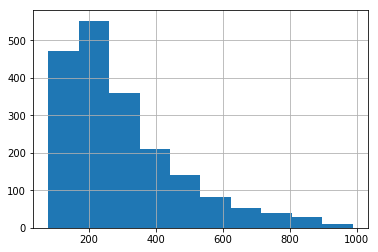

In [49]:
reddit_pred_df[reddit_pred_df.arg_len < 1000].arg_len.hist()

In [50]:
reddit_pred_df[reddit_pred_df.arg_len < 500][['argument', 'masked_conc_attacks', 'known_conc_attacks', 'bart_conc_attacks', 'joint_conc_attacks', 'best_counter']].sample(20).to_csv('../data/sample_prediction_on_test.csv')

-----------

#### Automatic evaluation:

In [85]:
pred_df_scores = get_evaluation_results(reddit_pred_df.sample(500), ceph_dir + data_path)

Testing stance on only 500 posts


ProConClient: 100%|██████████| 500/500 [00:03<00:00, 135.41it/s]
/usr/local/lib/python3.6/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [86]:
# stances_df = pred_df_scores['stances_df']
# stances_df[['conclusion', 'conclusion_stance', 'conclusion_target', 'masked_conc_stances', 'masked_conc_attacks', 'best_counter', 'multi_count_conc_stances']].head(n=20)

In [87]:
x = print_results(pred_df_scores, print_sig=True)

                                         bleu    bert-f1score    stance-score (diff)    arg-quality    stance-score-2
-----------------------------------  --------  --------------  ---------------------  -------------  ----------------
BART model                           0.12            0.07                       0.76           0.66             0.516
Masked Conclusion                    0.15            0.14                       0.81           0.7              0.716
BART Conclusion                      0.16            0.15                       0.85           0.71             0.738
Multi BART Conclusions               0.145845        0.142776                   0.83           0.71             0.77
Joint Prediction (One sequence)      0.16            0.16                       0.86           0.7              0.752
Joint Prediction (Two decoders)      0.16            0.15                       0.77           0.77             0.71
Joint Prediction (Claim -> support)  0.14            0.14 

#### Analyze effectiveness for different levels of similarity to conclusion:

In [16]:
reddit_pred_df = split_dataframe_per_conc_similarity(reddit_pred_df)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

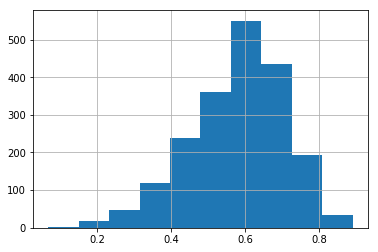

In [17]:
reddit_pred_df['max_sim_to_conclusion'].hist()

In [20]:
#Analyze scores on different levels of similarity to conclusion
sorted_df  = reddit_pred_df.sort_values('max_sim_to_conclusion')
num_chunks = 5
chunk_size = int(len(sorted_df)/num_chunks)
all_pred_scores = []
for i in range(0, num_chunks) :
    reddit_pred_df_chunk = sorted_df[i*chunk_size: (i+1) * chunk_size].copy()
    print('Number of samples is {} with average similarity to conclusion = {}'.format(len(reddit_pred_df_chunk), round(reddit_pred_df_chunk['max_sim_to_conclusion'].mean(), 2)))
    pred_df_scores = get_evaluation_results(reddit_pred_df_chunk, ceph_dir + data_path)
    print_results(pred_df_scores, print_sig=True)
    all_pred_scores.append(pred_df_scores)

Number of samples is 400 with average similarity to conclusion = 0.39
Testing stance on only 400 posts


ProConClient: 100%|██████████| 400/400 [00:09<00:00, 42.85it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.14            0.12                       0.83
BART Conclusion                       0.14            0.13                       0.81
Joint Prediction (baseline)           0.14            0.15                       0.82
Joint Prediction                      0.14            0.13                       0.79
Joint Prediction (dynamic weighting)  0.14            0.13                       0.79
Multi Conclusions                     0.134368        0.123065                   0.88
Known Conclusion                      0.17            0.16                       0.76
BART vs baseline (BLEU): False
BART vs baseline (BERT): True
BART vs baseline (STANCE): False
-------
Joint Prediction (baseline) vs baseline (BLEU): False
Joint Prediction (baseline) vs baseline (BERT): True
Joint Prediction 

ProConClient: 100%|██████████| 400/400 [00:07<00:00, 52.06it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.15            0.13                       0.9
BART Conclusion                       0.15            0.14                       0.86
Joint Prediction (baseline)           0.14            0.16                       0.87
Joint Prediction                      0.15            0.14                       0.81
Joint Prediction (dynamic weighting)  0.15            0.14                       0.81
Multi Conclusions                     0.139865        0.134201                   0.9
Known Conclusion                      0.18            0.16                       0.79
BART vs baseline (BLEU): False
BART vs baseline (BERT): True
BART vs baseline (STANCE): False
-------
Joint Prediction (baseline) vs baseline (BLEU): False
Joint Prediction (baseline) vs baseline (BERT): True
Joint Prediction (b

ProConClient: 100%|██████████| 400/400 [00:09<00:00, 42.98it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.16            0.14                       0.86
BART Conclusion                       0.16            0.15                       0.83
Joint Prediction (baseline)           0.16            0.17                       0.86
Joint Prediction                      0.16            0.15                       0.83
Joint Prediction (dynamic weighting)  0.16            0.15                       0.83
Multi Conclusions                     0.150709        0.144003                   0.84
Known Conclusion                      0.18            0.16                       0.8
BART vs baseline (BLEU): False
BART vs baseline (BERT): True
BART vs baseline (STANCE): False
-------
Joint Prediction (baseline) vs baseline (BLEU): False
Joint Prediction (baseline) vs baseline (BERT): True
Joint Prediction (

ProConClient: 100%|██████████| 400/400 [00:09<00:00, 42.23it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.16            0.15                       0.85
BART Conclusion                       0.16            0.16                       0.82
Joint Prediction (baseline)           0.16            0.17                       0.86
Joint Prediction                      0.16            0.16                       0.84
Joint Prediction (dynamic weighting)  0.16            0.16                       0.84
Multi Conclusions                     0.151598        0.157942                   0.91
Known Conclusion                      0.17            0.17                       0.79
BART vs baseline (BLEU): False
BART vs baseline (BERT): True
BART vs baseline (STANCE): False
-------
Joint Prediction (baseline) vs baseline (BLEU): False
Joint Prediction (baseline) vs baseline (BERT): True
Joint Prediction 

ProConClient: 100%|██████████| 400/400 [00:09<00:00, 44.10it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.17            0.17                       0.82
BART Conclusion                       0.17            0.17                       0.77
Joint Prediction (baseline)           0.17            0.19                       0.83
Joint Prediction                      0.18            0.17                       0.77
Joint Prediction (dynamic weighting)  0.18            0.17                       0.77
Multi Conclusions                     0.166252        0.166322                   0.9
Known Conclusion                      0.19            0.18                       0.83
BART vs baseline (BLEU): False
BART vs baseline (BERT): False
BART vs baseline (STANCE): False
-------
Joint Prediction (baseline) vs baseline (BLEU): False
Joint Prediction (baseline) vs baseline (BERT): True
Joint Prediction 

In [27]:
for s in all_pred_scores:
    x = print_results(s, print_sig=True)

                                        bleu    bert-f1score    stance-score (diff)
------------------------------------  ------  --------------  ---------------------
Masked Conclusion                       0.15            0.11                   0.79
BART Conclusion                         0.15            0.12                   0.79
Joint Prediction (baseline)             0.15            0.13                   0.79
Joint Prediction                        0.15            0.12                   0.79
Joint Prediction (dynamic weighting)    0.15            0.11                   0.76
Known Conclusion                        0.19            0.14                   0.68
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): True
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (bas



ProConClient: 100%|██████████| 400/400 [00:20<00:00, 65.03it/s]



ProConClient: 100%|██████████| 400/400 [00:19<00:00, 52.41it/s]


ProConClient: 100%|██████████| 400/400 [00:24<00:00, 84.59it/s]

#### Analyze effectiveness for different levels of argument length:

In [64]:
reddit_pred_df['arg_len'] = reddit_pred_df.premises.apply(lambda x: len(nltk.word_tokenize(x)))

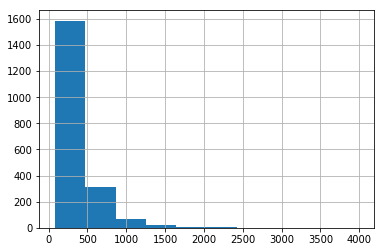

In [65]:
reddit_pred_df['arg_len'].hist()

In [66]:
#Analyze scores on different levels of argument length
sorted_df  = reddit_pred_df.sort_values('arg_len')
num_chunks = 5
chunk_size = int(len(sorted_df)/num_chunks)
all_pred_scores_per_len = []
for i in range(1, num_chunks) :
    reddit_pred_df_chunk = sorted_df[i*chunk_size: (i+1) * chunk_size].copy()
    print('Number of samples is {} with average similarity to conclusion = {}'.format(len(reddit_pred_df_chunk), round(reddit_pred_df_chunk['arg_len'].mean(), 2)))
    pred_df_scores = get_evaluation_results(reddit_pred_df_chunk, ceph_dir + data_path)
    print_results(pred_df_scores)
    all_pred_scores_per_len.append(pred_df_scores)

Number of samples is 400 with average similarity to conclusion = 192.72
Testing stance on only 400 posts


ProConClient: 100%|██████████| 400/400 [00:07<00:00, 56.61it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.16            0.15                       0.87
BART Conclusion                       0.16            0.16                       0.84
Joint Prediction (baseline)           0.16            0.18                       0.83
Joint Prediction                      0.17            0.16                       0.84
Joint Prediction (dynamic weighting)  0.17            0.16                       0.84
Multi Conclusions                     0.154466        0.154702                   0.88
Known Conclusion                      0.19            0.18                       0.78
Number of samples is 400 with average similarity to conclusion = 268.09
Testing stance on only 400 posts


ProConClient: 100%|██████████| 400/400 [00:08<00:00, 48.71it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.15            0.15                       0.85
BART Conclusion                       0.14            0.15                       0.81
Joint Prediction (baseline)           0.14            0.16                       0.84
Joint Prediction                      0.14            0.15                       0.81
Joint Prediction (dynamic weighting)  0.14            0.15                       0.81
Multi Conclusions                     0.146224        0.142769                   0.87
Known Conclusion                      0.17            0.16                       0.78
Number of samples is 400 with average similarity to conclusion = 385.92
Testing stance on only 400 posts


ProConClient: 100%|██████████| 400/400 [00:06<00:00, 64.19it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.16            0.14                       0.86
BART Conclusion                       0.16            0.15                       0.84
Joint Prediction (baseline)           0.15            0.16                       0.9
Joint Prediction                      0.15            0.14                       0.8
Joint Prediction (dynamic weighting)  0.15            0.14                       0.8
Multi Conclusions                     0.148378        0.136618                   0.93
Known Conclusion                      0.17            0.15                       0.79
Number of samples is 400 with average similarity to conclusion = 777.22
Testing stance on only 400 posts


ProConClient: 100%|██████████| 400/400 [00:07<00:00, 55.66it/s]


                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.15            0.12                       0.84
BART Conclusion                       0.15            0.13                       0.75
Joint Prediction (baseline)           0.15            0.14                       0.77
Joint Prediction                      0.15            0.13                       0.77
Joint Prediction (dynamic weighting)  0.15            0.13                       0.77
Multi Conclusions                     0.136439        0.123967                   0.85
Known Conclusion                      0.17            0.15                       0.76


In [67]:
for s in all_pred_scores_per_len:
    print_results(s)

                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.16            0.15                       0.87
BART Conclusion                       0.16            0.16                       0.84
Joint Prediction (baseline)           0.16            0.18                       0.83
Joint Prediction                      0.17            0.16                       0.84
Joint Prediction (dynamic weighting)  0.17            0.16                       0.84
Multi Conclusions                     0.154466        0.154702                   0.88
Known Conclusion                      0.19            0.18                       0.78
                                          bleu    bert-f1score    stance-score (diff)
------------------------------------  --------  --------------  ---------------------
Masked Conclusion                     0.15            

#### Analyzing results:

In [13]:
reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_with_sampling_df.pkl')
multi_counter_preds = pd.read_pickle('../data/output/multi_counter_preds.pkl')
reddit_pred_df = reddit_pred_df.merge(multi_counter_preds[['post_id', 'best_counter']], on=['post_id'])

df = pd.read_pickle(ceph_dir + data_path)
arg_counters = df.groupby('post_id').agg({
    'counter': lambda x: [' '.join(c) for c in x]
}).reset_index()

arg_counters = pd.Series(arg_counters.counter.values, index=arg_counters.post_id).to_dict()

reddit_pred_df['all_counters'] = reddit_pred_df['post_id'].apply(lambda x: arg_counters[x])

In [14]:
reddit_pred_df[['conclusion', 'known_conc_attacks', 'masked_conc_attacks', 'joint_conc_attacks', 'bart_conc_attacks', 'all_counters']].head(n=50)

conclusion  \
0                                                                                                                                                                                         All regions have access to basically the same ingredients so no city can truly have superior food to another   
1                                                                                                                                                                                                            People who earn more should pay less taxes and people who earn less should pay more taxes   
2                                                                                                            A Universal Basic Income of €/$/£1000 each month to every citizen over 18 years old cutting all other welfare payments will be beneficial to the economy, the citizens and the government   
3                                                                                                                                                                                                                                                                          Women already have equality   
4                                                                                                                                                                                                                                               only people that do violent crimes should go to prison   
5                                                                                                                                                                                                                                                                 rape culutre is perpetuated by women   
6                                                                                                                                                                                                             It isn't inherently racist for me to want to get my nails done at a non-Asian nail salon   
7                                                                                                                                                                                 posting pictures of your children on sites like Reddit is wrong, unethical, and we'll haunt parents later on in life   
8                                                                                                                                                                                                                           It is OK to consume entertainment made by criminals or morally bad people.   
9                                                                                                                                                                                                                                                               I've decided not to marry or have kids   
10                                                                                                                                                                                                                        Faithless electors shouldn't be legally allowed to vote against their pledge   
11                                                                                                                                                                   Living Wage laws are arbitrary because there is so much variation in costs of living, and there is no minimum standard of living.   
12                                                                                                                                                                                                                                                                                          God exists   
13                                                                                                              

In [33]:
sample_preds = reddit_pred_df.sample(100)

In [2]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [49]:
def exact_copies(t1, t2):
    doc1= nlp(t1)
    doc2= nlp(t2)
    
    sents2 = [s for s in doc2.sents]
    
    return [s1 for s1 in doc1.sents if s1 in sents2]

In [59]:
reddit_pred_df['known_conc_exact_copies'] = reddit_pred_df.apply(lambda row: exact_copies( row['known_conc_attacks'], row['argument']), axis=1)
reddit_pred_df['known_conc_num_exact_copies'] = reddit_pred_df.known_conc_exact_copies.apply(lambda x: len(x))
sum(reddit_pred_df.known_conc_num_exact_copies)

14

In [60]:
reddit_pred_df['masked_conc_exact_copies'] = reddit_pred_df.apply(lambda row: exact_copies( row['masked_conc_attacks'], row['argument']), axis=1)
reddit_pred_df['masked_conc_num_exact_copies'] = reddit_pred_df.masked_conc_exact_copies.apply(lambda x: len(x))
sum(reddit_pred_df.masked_conc_num_exact_copies)

5

In [61]:
reddit_pred_df['bart_conc_exact_copies'] = reddit_pred_df.apply(lambda row: exact_copies( row['bart_conc_attacks'], row['argument']), axis=1)
reddit_pred_df['bart_conc_num_exact_copies'] = reddit_pred_df.bart_conc_exact_copies.apply(lambda x: len(x))
sum(reddit_pred_df.bart_conc_num_exact_copies)

12

In [63]:
reddit_pred_df['best_counter_exact_copies'] = reddit_pred_df.apply(lambda row: exact_copies( row['best_counter'], row['argument']), axis=1)
reddit_pred_df['best_counter_num_exact_copies'] = reddit_pred_df.best_counter_exact_copies.apply(lambda x: len(x))
sum(reddit_pred_df.best_counter_num_exact_copies)

15

In [64]:
reddit_pred_df['joint_conc_exact_copies'] = reddit_pred_df.apply(lambda row: exact_copies( row['joint_conc_attacks'], row['argument']), axis=1)
reddit_pred_df['joint_conc_num_exact_copies'] = reddit_pred_df.joint_conc_exact_copies.apply(lambda x: len(x))
sum(reddit_pred_df.joint_conc_num_exact_copies)

13

---------

In [ ]:
def get_np(text):
    document = nlp(text)
    return [nc.text for nc in document.noun_chunks]

In [34]:
sample_preds['argument_nps'] = sample_preds.argument.apply(lambda x: get_np(x))
sample_preds['gt_nps'] = sample_preds.all_counters.apply(lambda counters: [[np for np in get_np(c)] for c in counters[:10]])